In [455]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.feature_selection import VarianceThreshold
import random
import pickle
from sklearn.preprocessing import StandardScaler
import os
import tensorflow as tf
from tqdm.notebook import tqdm
from scipy.stats import multivariate_normal as mvn
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
import warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

In [456]:
warnings.filterwarnings('ignore')

In [457]:
# len(weights_ann_1[0].ravel())

In [458]:
def get_targets_with_weights(batch_data, initial_ensembles, size_ens): 
    
    target_dim = 1
    
    # weights_ann_1 = ann.get_weights()
    
    # h1  = ann.layers[1].output.shape[-1]

    n_hidden_1 = len(weights_ann_1[0].ravel())
    
    hidden_weights_1 = initial_ensembles[:,:n_hidden_1].reshape( size_ens, batch_data.shape[1], h1)
    
    
    hidden_output_1 = np.einsum('ij,kjl->kil', batch_data, hidden_weights_1)

    
    hidden_layer_bias_1 = initial_ensembles[:,n_hidden_1:(n_hidden_1 + h1)].reshape(size_ens, 1,  h1)


    hidden_output_1 = hidden_output_1 + hidden_layer_bias_1

    n_pred_weights_1 = len(weights_ann_1[2].ravel())

    output_weights_1 = initial_ensembles[:,(n_hidden_1 + h1):(n_hidden_1 + h1 + n_pred_weights_1) ].reshape(size_ens, h1, target_dim)


    output_1 = np.einsum('ijk,ikl->ijl', hidden_output_1, output_weights_1)


    output_layer_bias_1 = initial_ensembles[:,(n_hidden_1 + h1 + n_pred_weights_1):(n_hidden_1 + h1 + n_pred_weights_1 + target_dim)].reshape(size_ens, 1, target_dim)


    final_output_1 = output_1 + output_layer_bias_1
    
    final_output_1 = final_output_1[:,:, 0]
    
    # print(final_output_1.shape, initial_ensembles.shape)
    
    stack = np.hstack((final_output_1, initial_ensembles))

    
    return final_output_1, stack

In [459]:
def ann(hidden = 32, input_shape = 256, output_shape = 1): 
    input_layer = tf.keras.layers.Input(shape = (input_shape))
    hidden_layer = tf.keras.layers.Dense(hidden)
    hidden_output = hidden_layer(input_layer)
    pred_layer = tf.keras.layers.Dense(output_shape, activation = "relu")
    pred_output = pred_layer(hidden_output)
#     pred_output = tf.keras.layers.Activation("softmax")(pred_output)
    model = tf.keras.models.Model(input_layer, pred_output)
    return model

In [460]:
def generate_initial_ensembles(num_weights, lambda1, size_ens):
    mean_vec = np.zeros((num_weights,))
    cov_matrix = lambda1*np.identity(num_weights)
    mvn_samp = mvn(mean_vec, cov_matrix)
    return mvn_samp.rvs(size_ens)

In [461]:
def expit(x):
    """Compute softmax values for each sets of scores in x."""
#     e_x = np.exp(x - np.max(x))
    return 1 / (1 + np.exp(-x))

In [462]:
samp_ann =  ann(hidden = 8, input_shape = 64, output_shape = 1)

In [463]:
weights_ann_1 = samp_ann.get_weights()

In [464]:
h1  = samp_ann.layers[1].output.shape[-1]

In [465]:
h1

8

In [466]:
samp_ann.count_params()

529

In [467]:
hidden_neurons = h1

In [468]:
samp_ann_params = samp_ann.count_params()

In [469]:
def get_initial_X_t(data1, data2, data3, data4, size_ens, var_weights = 1.0, var_weight_weights = 4.0, var_L = 1.0, var_D = 1.0):
    # samp_ann =  ann(hidden = hidden_neurons, input_shape = 32, output_shape = 1)
    
    initial_ensembles1 = generate_initial_ensembles(samp_ann_params, var_weights, size_ens)
    data1_out1, data1_stack1 = get_targets_with_weights(data1, initial_ensembles1, size_ens = size_ens)
    
    initial_ensembles2 = generate_initial_ensembles(samp_ann_params, var_weights, size_ens)
    data1_out2, data1_stack2 = get_targets_with_weights(data2, initial_ensembles2, size_ens = size_ens)
    
    initial_ensembles3 = generate_initial_ensembles(samp_ann_params, var_weights, size_ens)
    data2_out1, data2_stack1 = get_targets_with_weights(data3, initial_ensembles3, size_ens = size_ens)
    
    initial_ensembles4 = generate_initial_ensembles(samp_ann_params, var_weights, size_ens)
    data2_out2, data2_stack2 = get_targets_with_weights(data4, initial_ensembles4, size_ens = size_ens)   
    
    X_t = np.concatenate((np.expand_dims(data1_stack1, -1), np.expand_dims(data1_stack2, -1), 
                         np.expand_dims(data2_stack1, -1), np.expand_dims(data2_stack2, -1)), axis = -1)
    
    initial_ensembles_for_weights = generate_initial_ensembles(4, var_weight_weights, size_ens)
    initial_ensembles_for_weights = np.expand_dims(initial_ensembles_for_weights,1)
    
    # initial_ensembles_for_L = generate_initial_ensembles(4, var_L, size_ens)
    # initial_ensembles_for_L = np.expand_dims(initial_ensembles_for_L,1)    
    
    initial_ensembles_for_D1 = generate_initial_ensembles(1, var_D, size_ens).reshape(-1,1)
    # initial_ensembles_for_D2 = generate_initial_ensembles(1, var_D, size_ens).reshape(-1,1)
    
    initial_ensembles_for_D1_zero = np.zeros((size_ens,1,1)).reshape(-1,1)
    initial_ensembles_for_D2_zero = np.zeros((size_ens,1,1)).reshape(-1,1)
    
    initial_ensembles_for_D3_zero = np.zeros((size_ens,1,1)).reshape(-1,1)
    
    initial_ensembles_for_D = np.concatenate((np.expand_dims(initial_ensembles_for_D1,1),
                                                       np.expand_dims(initial_ensembles_for_D1_zero,1), 
                                                      np.expand_dims(initial_ensembles_for_D2_zero,1),
                                                       np.expand_dims(initial_ensembles_for_D3_zero,1)), axis = 2)
    
    # print(X_t.shape, initial_ensembles_for_weights.shape)
    
    X_t = np.concatenate((X_t, initial_ensembles_for_weights, initial_ensembles_for_D), axis = 1)
    
    initial_ensembles = np.hstack((initial_ensembles1, initial_ensembles2, initial_ensembles3, initial_ensembles4))
    
    return X_t, initial_ensembles, initial_ensembles_for_weights[:,0,:], initial_ensembles_for_D[:,0,:]

In [470]:
def get_weighted_targets_with_weights(batch_data, initial_ensembles, size_ens, weights): 
    
    target_dim = 1
    

    n_hidden_1 = len(weights_ann_1[0].ravel())
    
    hidden_weights_1 = initial_ensembles[:,:n_hidden_1].reshape( size_ens, batch_data.shape[1], h1)
    
    
    hidden_output_1 = np.einsum('ij,kjl->kil', batch_data, hidden_weights_1)

    
    hidden_layer_bias_1 = initial_ensembles[:,n_hidden_1:(n_hidden_1 + h1)].reshape(size_ens, 1,  h1)


    hidden_output_1 = hidden_output_1 + hidden_layer_bias_1

    n_pred_weights_1 = len(weights_ann_1[2].ravel())

    output_weights_1 = initial_ensembles[:,(n_hidden_1 + h1):(n_hidden_1 + h1 + n_pred_weights_1) ].reshape(size_ens, h1, target_dim)


    output_1 = np.einsum('ijk,ikl->ijl', hidden_output_1, output_weights_1)


    output_layer_bias_1 = initial_ensembles[:,(n_hidden_1 + h1 + n_pred_weights_1):(n_hidden_1 + h1 + n_pred_weights_1 + target_dim)].reshape(size_ens, 1, target_dim)


    final_output_1 = output_1 + output_layer_bias_1
    
    final_output_1 = final_output_1[:,:, 0]
    
    final_output_1 = final_output_1*weights
    
    # print(final_output_1.shape, initial_ensembles.shape)
    
    stack = np.hstack((final_output_1, initial_ensembles))

    
    return final_output_1, stack

In [471]:
from scipy.stats import beta

In [472]:
fudging_beta = beta(1,9)

In [473]:
def forward_operation(data1, data2, data3, data4, combined_ensembles , size_ens, fudging_beta):
    # samp_ann =  ann(hidden = hidden_neurons, input_shape = 32, output_shape = 1)
    params = samp_ann_params
    initial_ensembles1 = combined_ensembles[:, :params]
    initial_ensembles2 = combined_ensembles[:, params:(2*params)]
    initial_ensembles3 = combined_ensembles[:, (2*params):(3*params)]
    initial_ensembles4 = combined_ensembles[:, (3*params):(4*params)]

    
    initial_ensembles_for_weights = combined_ensembles[:, (4*params):(4*params + 4)]
    
    # initial_ensembles_for_L = combined_ensembles[:, (4*params + 4):(4*params + 4 + 4)]
    
    initial_ensembles_for_D = combined_ensembles[:,(4*params + 4):(4*params + 4 + 4 )]
    
    
    softmax_weights = tf.math.softmax(initial_ensembles_for_weights).numpy()
    
    model_1 = softmax_weights[:, 0].reshape(-1,1) 
    
    # model_1 = np.min(model_1 -fudging_factor)
    
    model_2 = softmax_weights[:, 1].reshape(-1,1) 
    
    model_3 = softmax_weights[:, 2].reshape(-1,1) 
    
    model_4 = softmax_weights[:, 3].reshape(-1,1)
    
    sum_weights = model_1 + model_2 + model_3 + model_4
    
    
    # model_1_plus_model_2 = model_1 + model_2
    
    model_1 = model_1/sum_weights
    
    model_2 = model_2/sum_weights
    
    model_3 = model_3/sum_weights
    
    model_4 = model_4/sum_weights
    
    
    # print(np.mean(model_1 + model_2))
    
    data1_out1, data1_stack1 = get_weighted_targets_with_weights(data1, initial_ensembles1, size_ens = size_ens,
                                                                  weights=model_1)
    
    data1_out2, data1_stack2 = get_weighted_targets_with_weights(data2, initial_ensembles2, size_ens = size_ens,
                                                                weights=model_2)
    
    data2_out1, data2_stack1 = get_weighted_targets_with_weights(data3, initial_ensembles3, size_ens = size_ens,
                                                                 weights=model_3)
    
    data2_out2, data2_stack2 = get_weighted_targets_with_weights(data4, initial_ensembles4, size_ens = size_ens,
                                                                  weights=model_4)   
    
    X_t = np.concatenate((np.expand_dims(data1_stack1, -1), np.expand_dims(data1_stack2, -1), 
                         np.expand_dims(data2_stack1, -1), np.expand_dims(data2_stack2, -1)), axis = -1)
    
    initial_ensembles = np.hstack((initial_ensembles1, initial_ensembles2, initial_ensembles3, initial_ensembles4, 
                        initial_ensembles_for_weights, initial_ensembles_for_D))
    
    # print(X_t.shape)
    
    initial_ensembles_for_weights = np.expand_dims(initial_ensembles_for_weights,1)
    
    # initial_ensembles_for_L = np.expand_dims(initial_ensembles_for_L,1)
    
    initial_ensembles_for_D = np.expand_dims(initial_ensembles_for_D,1)
    
    # print(initial_ensembles_for_weights.shape)
    
    X_t = np.concatenate((X_t, initial_ensembles_for_weights, initial_ensembles_for_D), axis = 1)
    
    final_output = data1_out1 + data1_out2 + data2_out1 + data2_out2
    
    # weighted_psa = data1_out2 + data2_out2
    
    return X_t, initial_ensembles,final_output, model_1, model_2, model_3, model_4

In [474]:
def forward_operation_test(data1, data2, data3, data4, combined_ensembles , size_ens):
    # samp_ann =  ann(hidden = hidden_neurons, input_shape = 32, output_shape = 1)
    params = samp_ann_params
    initial_ensembles1 = combined_ensembles[:, :params]
    initial_ensembles2 = combined_ensembles[:, params:(2*params)]
    initial_ensembles3 = combined_ensembles[:, (2*params):(3*params)]
    initial_ensembles4 = combined_ensembles[:, (3*params):(4*params)]

    
    initial_ensembles_for_weights = combined_ensembles[:, (4*params):(4*params + 4)]
    
    # initial_ensembles_for_L = combined_ensembles[:, (4*params + 4):(4*params + 4 + 4)]
    
    initial_ensembles_for_D = combined_ensembles[:,(4*params + 4):(4*params + 4 + 4)]
    
    
    softmax_weights = tf.math.softmax(initial_ensembles_for_weights).numpy()
    
    model_1 = softmax_weights[:, :1].reshape(-1,1) 
    
    # model_1 = np.min(model_1 -fudging_factor)
    
    model_2 = softmax_weights[:, 1:2].reshape(-1,1) 
    
    model_3 = softmax_weights[:, 2:3].reshape(-1,1)
    
    model_4 = softmax_weights[:, 3:4].reshape(-1,1)
    
    sum_weights = model_1 + model_2 + model_3 + model_4
    
    
    # model_1_plus_model_2 = model_1 + model_2
    
    model_1 = model_1/sum_weights
    
    model_2 = model_2/sum_weights
    
    model_3 = model_3/sum_weights
    
    model_4 = model_4/sum_weights
    
    data1_out1, data1_stack1 = get_weighted_targets_with_weights(data1, initial_ensembles1, size_ens = size_ens,
                                                                  weights=model_1)
    
    data1_out2, data1_stack2 = get_weighted_targets_with_weights(data2, initial_ensembles2, size_ens = size_ens,
                                                                weights=model_2)
    
    data2_out1, data2_stack1 = get_weighted_targets_with_weights(data3, initial_ensembles3, size_ens = size_ens,
                                                                 weights=model_3)
    
    data2_out2, data2_stack2 = get_weighted_targets_with_weights(data4, initial_ensembles4, size_ens = size_ens,
                                                                  weights=model_4)   
    
    X_t = np.concatenate((np.expand_dims(data1_stack1, -1), np.expand_dims(data1_stack2, -1), 
                         np.expand_dims(data2_stack1, -1), np.expand_dims(data2_stack2, -1)), axis = -1)
    
    initial_ensembles = np.hstack((initial_ensembles1, initial_ensembles2, initial_ensembles3, initial_ensembles4, 
                        initial_ensembles_for_weights, initial_ensembles_for_D))
    
    # print(X_t.shape)
    
    initial_ensembles_for_weights = np.expand_dims(initial_ensembles_for_weights,1)
    
    # initial_ensembles_for_L = np.expand_dims(initial_ensembles_for_L,1)
    
    initial_ensembles_for_D = np.expand_dims(initial_ensembles_for_D,1)
    
    # print(initial_ensembles_for_weights.shape)
    
    X_t = np.concatenate((X_t, initial_ensembles_for_weights, initial_ensembles_for_D), axis = 1)
    
    final_output = data1_out1 + data1_out2 + data2_out1 + data2_out2
    
    return X_t, initial_ensembles, final_output, model_1, model_2, model_3, model_4

In [475]:
total_weights = 4*(samp_ann.count_params() + 1 + 1)

In [476]:
reduction = 20

In [477]:
size_ens = total_weights//reduction
# total_weights//reduction

In [478]:
size_ens

106

In [479]:
G_t = [[1, 1, 1, 1]]
G_t = np.array(G_t).T

In [480]:
G_t.shape

(4, 1)

In [481]:
def get_predictions(data1, data2, data3, data4, initial_ensembles, fudging_beta  =fudging_beta): 
    _,_, weighted_alogp, w1, w2, w3, w4 = forward_operation(data1, data2, data3, data4, initial_ensembles, size_ens = size_ens, fudging_beta = fudging_beta)
    return weighted_alogp, w1, w2, w3, w4

In [482]:
def get_predictions_test(data1, data2, data3, data4, initial_ensembles): 
    _,_, weighted_alogp, w1, w2, w3, w4 = forward_operation_test(data1, data2, data3, data4, initial_ensembles, size_ens = size_ens)
    return weighted_alogp, w1, w2, w3, w4

In [483]:
def calculate_mu_bar_G_bar(data1, data2, data3, data4, initial_ensembles, fudging_beta):
    H_t = np.hstack((np.identity(data1.shape[0]), np.zeros((data1.shape[0], samp_ann_params + 1  + 1))))
    mu_bar = initial_ensembles.mean(0)
    X_t, _,_, _, _, _, _ = forward_operation(data1, data2, data3, data4, initial_ensembles, size_ens = size_ens, fudging_beta = fudging_beta)
    X_t = X_t.transpose((0,2,1))
    X_t = X_t.reshape(X_t.shape[0], X_t.shape[1]*X_t.shape[2])
    script_H_t = np.kron(G_t.T, H_t)
    G_u = (script_H_t@X_t.T)
    G_u = G_u.T
    G_bar = (G_u.mean(0)).ravel()
    return mu_bar.reshape(-1,1), G_bar.reshape(-1,1), G_u

In [484]:
def calculate_C_u(initial_ensembles, mu_bar, G_bar, G_u): 
    u_j_minus_u_bar = initial_ensembles - mu_bar.reshape(1,-1)
    G_u_minus_G_bar = G_u -  G_bar.reshape(1,-1)
    c = np.zeros((total_weights, G_bar.shape[0]))
    for i in range(0, size_ens): 
        c += np.kron(u_j_minus_u_bar[i, :].T.reshape(-1,1), G_u_minus_G_bar[i,:].reshape(-1,1).T)
    return c/size_ens, G_u_minus_G_bar

In [485]:
def calculate_D_u( G_bar, G_u): 
    G_u_minus_G_bar = G_u -  G_bar.reshape(1,-1)
    d = np.zeros((G_bar.shape[0], G_bar.shape[0]))
    for i in range(0, size_ens): 
        d += np.kron(G_u_minus_G_bar[i,:].T.reshape(-1,1), G_u_minus_G_bar[i,:].reshape(-1,1).T)
    return d/size_ens

In [486]:
def get_updated_ensemble(data1, data2, data3, data4, initial_ensembles, y_train, size_ens = size_ens, inflation_factor = 1.0, fudging_beta = fudging_beta, 
                        fudging_var = None):
    mu_bar, G_bar, G_u = calculate_mu_bar_G_bar(data1, data2, data3, data4, initial_ensembles, fudging_beta)
    C, G_u_minus_G_bar = calculate_C_u(initial_ensembles, mu_bar, G_bar, G_u)
    D = calculate_D_u( G_bar, G_u)
    _, R_t = create_cov(data1.shape[0],initial_ensembles)
    inflation = np.identity(R_t.shape[0])*inflation_factor
    D_plus_cov = D + (R_t *inflation_factor)
    D_plus_cov_inv = np.linalg.inv(D_plus_cov)
    mid_quant = C@D_plus_cov_inv
    noise_vec_mean = np.zeros((R_t.shape[0], ))
    noise_mvn = mvn(noise_vec_mean, R_t)
    fudging = noise_mvn.rvs(size_ens)
    interim = (y_train.T.flatten().reshape(1,-1) + fudging)
    right_quant = interim - G_u
    mid_times_right = mid_quant@right_quant.T
    updated_ensemble = (initial_ensembles + mid_times_right.T)
    if fudging_var is not None: 
        mean_vec = np.zeros((updated_ensemble.shape[1],))
        cov_mat = np.identity(updated_ensemble.shape[1])*fudging_var
        fudging_for_updated_ensembles = mvn(mean_vec, cov_mat)
        fudging_for_updated_ensembles_vec = fudging_for_updated_ensembles.rvs(size_ens)
        updated_ensemble = updated_ensemble + fudging_for_updated_ensembles_vec
    return updated_ensemble

In [487]:
target_dim = 1

In [488]:
lambda_D = 1

In [489]:
from joblib import Parallel, delayed

In [490]:
def create_cov(shape, initial_ensembles):
    cov_part = initial_ensembles[:, -4:-3]
    cov_part = cov_part.mean(0)
    variances1 = tf.math.softplus(cov_part).numpy()
    n = shape
    return variances1, np.identity(n)*variances1

In [491]:
# idx = 1

In [492]:
with open("..//Data//gcn_cdr_train_pca_higher.pickle", "rb") as f: 
    catch_train = pickle.load(f)

In [493]:
with open("..//Data//gcn_cdr_test_pca_higher.pickle", "rb") as f: 
    catch_test = pickle.load(f)

In [494]:
import random

In [495]:
def prepare_data_train(catch_train, idxes): 
    # idxes = random.sample(range(0, catch_train[0].shape[0]), k = size)
    # idxes = list(idxes)
    data1, data2, data3, data4 = catch_train[0][idxes,:], catch_train[1][idxes,:], catch_train[2][idxes,:], catch_train[3][idxes,:]
    
    y_train = catch_train[-1][idxes].reshape(-1,1)
    
    return data1, data2, data3, data4, y_train 

In [496]:
def prepare_data_test( catch_test, size): 
    idxes = random.sample(range(0, catch_test[0].shape[0]), k = size)
    idxes = list(idxes)
    data1, data2, data3, data4 = catch_test[0][idxes,:], catch_test[1][idxes,:], catch_test[2][idxes,:], catch_test[3][idxes,:]
    y_train = catch_test[-1][idxes].reshape(-1,1)
    return data1, data2, data3, data4, y_train

In [497]:
# data1_train, data2_train, data3_train, data4_train, y_train =  prepare_data_train(catch_train, size = 5000)

In [498]:
data1_test, data2_test, data3_test, data4_test, y_test =  prepare_data_test(catch_test, size = catch_test[0].shape[0])

In [499]:
from scipy.stats import pearsonr

In [500]:
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

In [501]:
batch_size = 2500

In [502]:
import random

In [503]:
from tqdm import tqdm_notebook

In [504]:
def get_results(idx, var_weights = 1.0, var_weight_weights = 1.0, var_D = 0.01, inflation_factor = 1.6, fudging_beta = beta(1,19), 
               fudging_var = 1e-3, print_true = True):
    
    # smiles_feats_train, rdkit_feats_train, smiles_feats_valid, rdkit_feats_valid, y_train, y_train_actual, y_valid, y_valid_actual, initial_ensembles  = prepare_data(idx, var_weights = var_weights, var_weight_weights =var_weight_weights, var_L = var_L, var_D = var_D)
    

    train_rmse = []
    test_rmse = []
    # print("done initializing")
    
    w1_catch = []
    w2_catch = []
    w3_catch = []
    w4_catch = []
    
    
    train_idxes = random.sample(range(0, catch_train[0].shape[0]), k = catch_train[0].shape[0])
    
    train_chunks = list(chunks(train_idxes, batch_size))
    
    best_rmse_train = 10000
    
    data1_train, data2_train, data3_train, data4_train, y_train = prepare_data_train(catch_train, train_chunks[0])
    
    _, initial_ensembles, initial_ensembles_for_weights, initial_ensembles_for_D = get_initial_X_t(data1_train, data2_train, data3_train, data4_train,
                                                                                                 size_ens = size_ens, var_weights = var_weights,
                                                                                                var_weight_weights = var_weight_weights,
                                                                                                             var_D = var_D)
    
    initial_ensembles = np.hstack((initial_ensembles, initial_ensembles_for_weights, initial_ensembles_for_D))
    patience = 0
    
    for i in range(0,300):
        
        train_chunks = random.sample(train_chunks, len(train_chunks))
        
        if print_true == True:
            print("epoch number is " +str(i))
        
        for chunk in (train_chunks):
        
            data1_train, data2_train, data3_train, data4_train, y_train = prepare_data_train(catch_train, chunk)
            
            # X_t, initial_ensembles, initial_ensembles_for_weights, initial_ensembles_for_D = get_initial_X_t(data1_train, data2_train, data3_train, data4_train,
            #                                                                                      size_ens = size_ens, var_weights = var_weights,
            #                                                                                     var_weight_weights = var_weight_weights,
            #                                                                                                  var_D = var_D)
            
            # initial_ensembles = np.hstack((initial_ensembles, initial_ensembles_for_weights, initial_ensembles_for_D))

            initial_ensembles = get_updated_ensemble(data1_train, data2_train, data3_train, data4_train, initial_ensembles, y_train, size_ens = size_ens,
                                                 inflation_factor = inflation_factor, fudging_beta = fudging_beta, fudging_var = fudging_var)
        
            G_u_train, w1, w2, w3, w4 = get_predictions(data1_train, data2_train, data3_train, data4_train, initial_ensembles, fudging_beta)
    
            li_train = np.percentile(G_u_train, axis = 0, q = (2.5, 97.5))[0,:].reshape(-1,1)    
            ui_train = np.percentile(G_u_train, axis = 0, q = (2.5, 97.5))[1,:].reshape(-1,1)  
    
            width_train = ui_train - li_train
            avg_width_train = width_train.mean(0)[0]
    
            ind_train = (y_train >= li_train) & (y_train <= ui_train)
            coverage_train= ind_train.mean(0)[0]
    
            averaged_targets_train = G_u_train.mean(0).reshape(-1,1)
            rmse_train = np.sqrt(((y_train -averaged_targets_train)**2).mean(0))[0]
        
            pearsonr_train = pearsonr(averaged_targets_train.reshape(averaged_targets_train.shape[0],), 
                                 y_train.reshape(y_train.shape[0],))
        
            r_train = pearsonr_train.statistic
    
            G_u_test, _, _, _, _ = get_predictions_test(data1_test, data2_test, data3_test, data4_test, initial_ensembles)
    

    
            li_test = np.percentile(G_u_test, axis = 0, q = (2.5, 97.5))[0,:].reshape(-1,1)     
            ui_test = np.percentile(G_u_test, axis = 0, q = (2.5, 97.5))[1,:].reshape(-1,1)   
    
            width_test = ui_test - li_test
            avg_width_test = width_test.mean(0)[0]
    
            ind_test = (y_test >= li_test) & (y_test <= ui_test)
            coverage_test= ind_test.mean(0)[0]
    
            averaged_targets_test = G_u_test.mean(0).reshape(-1,1)
            rmse_test = np.sqrt(((y_test -averaged_targets_test)**2).mean(0))[0]  
        
            pearsonr_test = pearsonr(averaged_targets_test.reshape(averaged_targets_test.shape[0],), 
                                 y_test.reshape(y_test.shape[0],))
        
            r_test = pearsonr_test.statistic
            
            train_rmse.append(rmse_train)
            
            test_rmse.append(rmse_test)
            
            
            if print_true == True:
                print("Training Coverage, Widths, RMSE, and Pearson R")
                print(coverage_train, avg_width_train, rmse_train, r_train)
                print("Testing Coverage, Widths, RMSE, and Pearson R")
                print(coverage_test, avg_width_test, rmse_test, r_test)
                print("Weight 1 Stats")
                print(w1.mean(), w1.std())
                print("Weight 2 Stats")
                print(w2.mean(), w2.std())
                print("Weight 3 Stats")
                print(w3.mean(), w3.std())
                print("Weight 4 Stats")
                print(w4.mean(), w4.std())
            
            w1_catch.append([w1.mean(), w1.std()])
            w2_catch.append([w2.mean(), w2.std()])
            w3_catch.append([w3.mean(), w3.std()])
            w4_catch.append([w4.mean(), w4.std()])
            

            if (rmse_train < best_rmse_train): 
                best_pearsonr_train = r_train
            # print("went here")
                best_train_width_mean = avg_width_train.mean()
                best_train_width = avg_width_train
                # best_smiles_weight = w1.mean()
                best_coverage_train = coverage_train
                best_rmse_train = rmse_train
                best_pearson_r = r_test
                best_test_width = avg_width_test

                best_coverage_test = coverage_test    
                best_rmse_test = rmse_test
                patience = 0
                best_ensembles = initial_ensembles
                
                best_w1_weight = w1.mean()
                best_w2_weight = w2.mean()
                best_w3_weight = w3.mean()
                best_w4_weight = w4.mean()
            
            else:
                patience = patience + 1
            
            if print_true == True:
                print("Patience is")
                print(patience)
                print('\n')
        
            if patience > threshold:
                # print("train_coverage" + str(best_coverage_train), flush = True)
                print("test_coverage" + str(best_coverage_test), flush = True)
                # print("train_width" + str(best_train_width.tolist()), flush = True)
                print("test_width" + str(best_test_width), flush = True)
                # print("smiles_weight" + str(best_smiles_weight), flush = True)
                # print("rmse_train" + str(best_rmse_train.tolist()), flush = True)
                print("rmse_test" + str(best_rmse_test), flush = True)
                weights = [best_w1_weight, best_w2_weight, best_w3_weight, best_w4_weight]
                print("weights", flush = True)
                print(weights, flush = True)
                print('\n', flush = True)
                # print("smiles_weight_ci" + str([best_li_smiles_weight, best_ui_smiles_weight]), flush = True)
            
                return [best_train_width, best_coverage_train, best_rmse_train, best_test_width, best_coverage_test, best_rmse_test, best_pearson_r, best_ensembles, train_rmse, test_rmse, w1_catch, w2_catch, w3_catch, w4_catch, best_w1_weight, best_w2_weight, best_w3_weight, best_w4_weight]


In [505]:
threshold = 10

In [506]:
%%time
best_train_width, best_coverage_train, best_rmse_train, best_test_width, best_coverage_test, best_rmse_test, best_pearson_r,  \
best_ensembles, train_rmse, test_rmse,   w1_catch, w2_catch, w3_catch, w4_catch, best_w1_weight, best_w2_weight, best_w3_weight, best_w4_weight = get_results(0, var_weights = 1.0, var_weight_weights = 1.0, var_D = 1, inflation_factor =1, fudging_beta = beta(1,19), 
           fudging_var = 1*1e-2, print_true = True)

epoch number is 0
Training Coverage, Widths, RMSE, and Pearson R
0.4032 4.5077751897254466 4.050586601066439 0.06450136488816018
Testing Coverage, Widths, RMSE, and Pearson R
0.3842688842688843 4.507347558642616 4.075108317248349 0.06911875621793936
Weight 1 Stats
0.11618809519904037 0.011262698412377885
Weight 2 Stats
0.25411622131264777 0.021629857272658117
Weight 3 Stats
0.21983037785305545 0.02131888386700045
Weight 4 Stats
0.40986530563525647 0.030640434337868023
Patience is
0


Training Coverage, Widths, RMSE, and Pearson R
0.5836 5.578635118935572 3.1838064288543246 0.221679966088737
Testing Coverage, Widths, RMSE, and Pearson R
0.5947100947100947 5.545349893641461 3.091766340505873 0.2341440399462655
Weight 1 Stats
0.123150910796889 0.013678462546649636
Weight 2 Stats
0.190188940678396 0.018560584926657065
Weight 3 Stats
0.334630134218671 0.02691814715282853
Weight 4 Stats
0.352030014306044 0.026144444781551878
Patience is
0


Training Coverage, Widths, RMSE, and Pearson R
0.75

In [507]:
preds_test, _, _, _, _ = get_predictions_test(data1_test, data2_test, data3_test, data4_test, best_ensembles)

In [508]:
averaged_preds_test = preds_test.mean(0).reshape(-1,1)

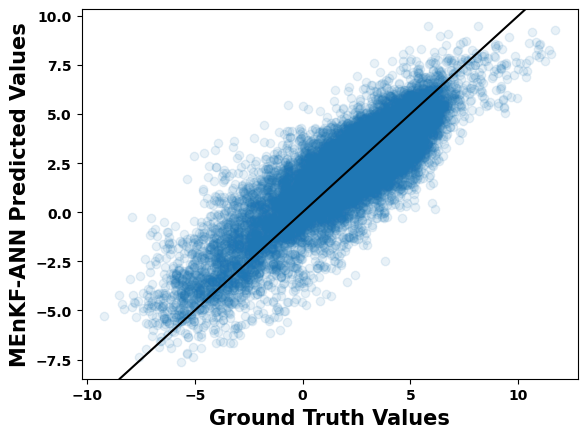

In [509]:
fig = plt.figure()
plt.scatter(y_test, averaged_preds_test, alpha = 0.1)
plt.axline((0,0), slope = 1, c = "black")
plt.xlabel("Ground Truth Values", fontweight = "bold",fontsize = 15)
plt.ylabel("MEnKF-ANN Predicted Values", fontweight = "bold", fontsize = 15)
plt.xticks(fontsize = 10, fontweight = "bold")
plt.yticks(fontsize = 10, fontweight = "bold")
fig.savefig('MEnKF_DeepCDR_DualGCN_Scatterplot.pdf', bbox_inches='tight', format = "pdf")
fig.savefig('MEnKF_DeepCDR_DualGCN_Scatterplot.png', bbox_inches='tight')
plt.show()

In [510]:
items = [best_train_width, best_coverage_train, best_rmse_train, best_test_width, best_coverage_test, best_rmse_test, best_pearson_r, best_w1_weight, best_w2_weight, best_w3_weight, best_w4_weight]

In [511]:
items_df = pd.DataFrame(items).T

In [512]:
items_df.columns = ['best_train_width', 'best_coverage_train', 'best_rmse_train', 'best_test_width', 'best_coverage_test', 'best_rmse_test', 'best_pearson_r', 
                   'best_w1_weight', 'best_w2_weight', 'best_w3_weight', 'best_w4_weight']

In [513]:
items_df = items_df.T

In [514]:
items_df.columns = ["Value"]

In [515]:
items_df

,Value
best_train_width,4.038285
best_coverage_train,0.872229
best_rmse_train,1.304649
best_test_width,4.028183
best_coverage_test,0.838300
best_rmse_test,1.427054
best_pearson_r,0.863764
best_w1_weight,0.032641
best_w2_weight,0.107172
best_w3_weight,0.598694


In [516]:
preds_test.shape

(106, 17316)

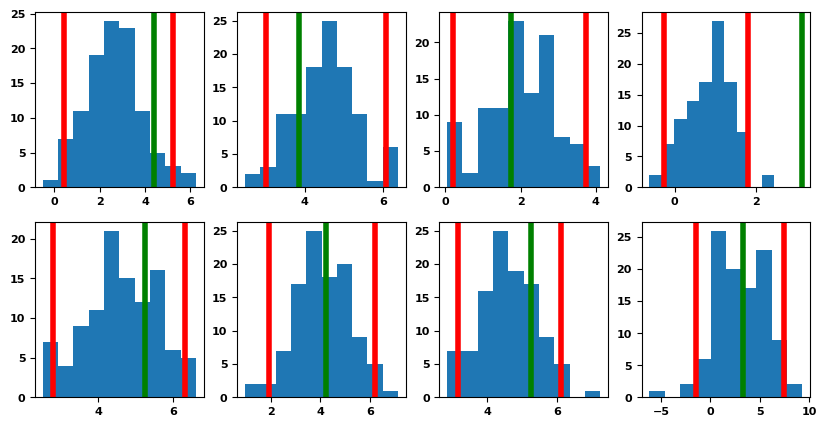

In [531]:
random_idx = random.sample(range(y_test.shape[0]), k = 8)
fig, axs = plt.subplots(2, 4,figsize=(10, 5))
# fig, axs = plt.subplots(4, 2)
axs = axs.ravel()
for idx, i in enumerate(random_idx):
    # print(counter)
    truth = y_test[i,:]
    preds = preds_test[:, i]
    percts = np.percentile(preds, axis = 0, q = (2.5, 97.5))
    lis = percts[0]
    uis = percts[1]
    
    
    axs[idx].hist(preds)
    axs[idx].axvline(truth, color='green', linewidth=4)
    axs[idx].axvline(lis, color='red', linewidth=4)
    axs[idx].axvline(uis, color='red', linewidth=4)
    plt.setp(axs[idx].get_xticklabels(), fontsize=8, fontweight="bold"
        )
    
    plt.setp(axs[idx].get_yticklabels(), fontsize=8, fontweight="bold")

# plt.title
fig.savefig('MEnKF_DeepCDR_DualGCN_Histogram.pdf', bbox_inches='tight', format = "pdf")
fig.savefig('MEnKF_DeepCDR_DualGCN_Histogram.png', bbox_inches='tight')
plt.show()


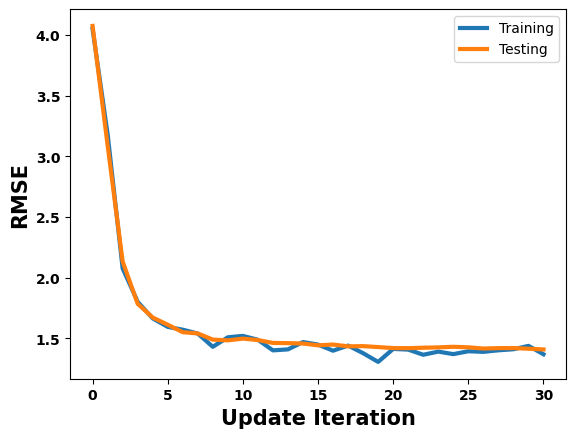

In [518]:
fig = plt.figure()
plt.plot(train_rmse, label = "Training", linewidth = 3)
plt.plot(test_rmse, label = "Testing", linewidth = 3)
plt.xlabel("Update Iteration", fontsize = 15, fontweight = "bold")
plt.ylabel("RMSE", fontsize = 15, fontweight = "bold")
plt.xticks( fontsize = 10, fontweight = "bold")
plt.yticks( fontsize = 10, fontweight = "bold")
plt.legend()
fig.savefig('MEnKF_DeepCDR_DualGCN_RMSE_Trajectories.pdf', bbox_inches='tight', format = "pdf")
fig.savefig('MEnKF_DeepCDR_DualGCN_RMSE_Trajectories.png', bbox_inches='tight')
plt.show()

In [519]:
# plt.hist(y_train)
# plt.show()

In [520]:
# w1_catch

In [521]:
len(w1_catch)

31

In [522]:
np.array(w1_catch)[:,0]

array([0.1161881 , 0.12315091, 0.1018929 , 0.07404026, 0.07303317,
       0.09128041, 0.08639093, 0.07609557, 0.05946925, 0.04700538,
       0.04260767, 0.04139986, 0.03824099, 0.04007006, 0.04280518,
       0.04249299, 0.04095342, 0.0376908 , 0.0359916 , 0.03264056,
       0.03503379, 0.02963766, 0.03138688, 0.03234462, 0.03310506,
       0.03618803, 0.03046055, 0.03498512, 0.03656817, 0.03060198,
       0.03015322])

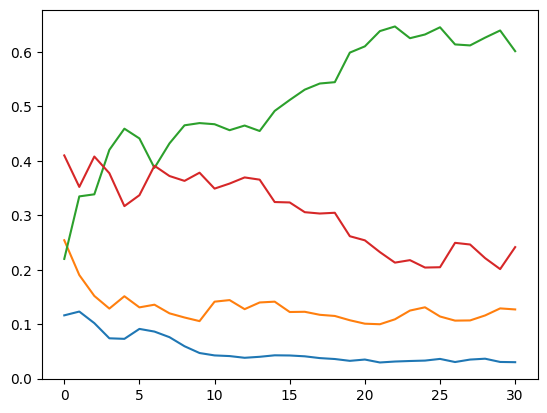

In [523]:
plt.plot(range(0,len(w1_catch)), np.array(w1_catch)[:,0])

plt.plot(range(0,len(w1_catch)), np.array(w2_catch)[:,0])

plt.plot(range(0,len(w1_catch)), np.array(w3_catch)[:,0])

plt.plot(range(0,len(w1_catch)), np.array(w4_catch)[:,0])

plt.show()

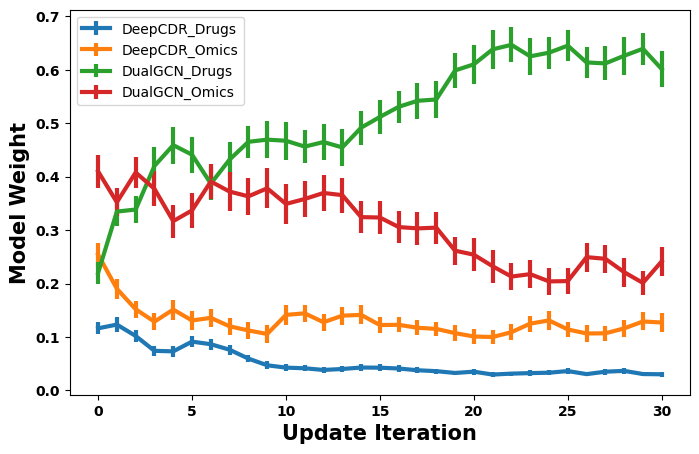

In [524]:
fig = plt.figure(figsize=(8, 5))
plt.errorbar(range(0,len(w1_catch)), np.array(w1_catch)[:,0], yerr=np.array(w1_catch)[:,1], 
            label = "DeepCDR_Drugs", linewidth = 3)

plt.errorbar(range(0,len(w1_catch)), np.array(w2_catch)[:,0], yerr=np.array(w2_catch)[:,1], 
            label = "DeepCDR_Omics", linewidth = 3)

plt.errorbar(range(0,len(w1_catch)), np.array(w3_catch)[:,0], yerr=np.array(w3_catch)[:,1], 
            label = "DualGCN_Drugs", linewidth = 3)

plt.errorbar(range(0,len(w1_catch)), np.array(w4_catch)[:,0], yerr=np.array(w4_catch)[:,1], 
            label = "DualGCN_Omics", linewidth = 3)

plt.xlabel("Update Iteration", fontsize = 15, fontweight = "bold")
plt.ylabel("Model Weight", fontsize = 15, fontweight = "bold")
plt.xticks( fontsize = 10, fontweight = "bold")
plt.yticks( fontsize = 10, fontweight = "bold")

plt.legend()
fig.savefig('MEnKF_DeepCDR_DualGCN_Weight_Trajectories.pdf', bbox_inches='tight', format = "pdf")
fig.savefig('MEnKF_DeepCDR_DualGCN_Weight_Trajectories.png', bbox_inches='tight')

plt.show()

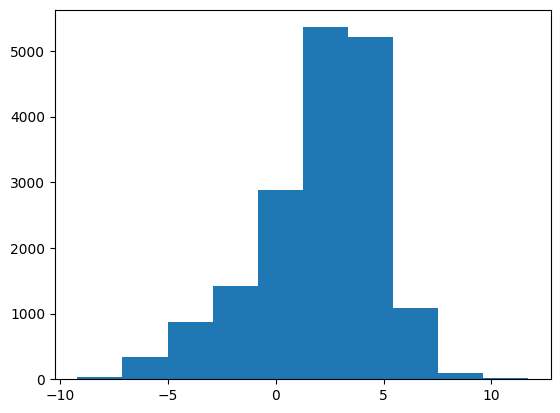

In [525]:
plt.hist(y_test)
plt.show()

In [ ]:
catch = Parallel(n_jobs = 14, verbose = 8, backend = "loky")(delayed(get_results)(idx, var_weights = 1.0, var_weight_weights = 1.0, var_D = 1, inflation_factor =1, fudging_beta = beta(1,19), 
           fudging_var = 1*1e-2, print_true = False) for idx in range(0,50))

In [ ]:
with open("..//Data//DeepCDR_DualGCN_combo_run.pickle", "wb") as f: 
    pickle.dump(catch, f)

In [160]:
import pickle

In [161]:
with open("..//Data//DeepCDR_DualGCN_combo_run.pickle", "rb") as f: 
    catch = pickle.load(f)

In [162]:
all_metrics = []
all_weights = []
for i in range(0,50):
    item = catch[i]
    metrics = item[:7]
    weights = item[-4:]
    all_metrics.append(metrics)
    all_weights.append(weights)
    

In [163]:
import pandas as pd

In [164]:
all_metrics_df = pd.DataFrame(all_metrics)

In [165]:
all_weights_df = pd.DataFrame(all_weights)

In [166]:
all_df = pd.concat([all_metrics_df, all_weights_df], axis = 1)

In [167]:
all_df.columns = ['train_width', 'coverage_train', 'rmse_train', 'test_width', 'coverage_test', 'rmse_test', 'pearson_r', 
                   "DeepCDR_Drugs", "DeepCDR_Omics", "DualGCN_Drugs", "DualGCN_Omics"]

In [168]:
all_df.head()

,train_width,coverage_train,rmse_train,test_width,coverage_test,rmse_test,pearson_r,DeepCDR_Drugs,DeepCDR_Omics,DualGCN_Drugs,DualGCN_Omics
0,9.082859,0.988400,1.378314,9.077162,0.987353,1.421503,0.865066,0.101757,0.537627,0.339417,0.021199
1,4.872920,0.902400,1.352588,4.892838,0.889640,1.412056,0.866803,0.029858,0.026280,0.366218,0.577644
2,3.279871,0.761600,1.343543,3.319063,0.743878,1.419871,0.865706,0.018767,0.070226,0.815669,0.095338
3,4.071027,0.861727,1.322039,4.048252,0.841245,1.401276,0.868964,0.021358,0.043856,0.612381,0.322405
4,7.931937,0.968800,1.517432,7.947606,0.966158,1.546736,0.837751,0.129053,0.165816,0.438829,0.266302


In [169]:
all_df.mean()

train_width       6.329512
coverage_train    0.891851
rmse_train        1.392818
test_width        6.345579
coverage_test     0.879897
rmse_test         1.456276
pearson_r         0.857166
DeepCDR_Drugs     0.074468
DeepCDR_Omics     0.116747
DualGCN_Drugs     0.633406
DualGCN_Omics     0.175379
dtype: float64

In [170]:
all_df.std()

train_width       4.170541
coverage_train    0.083419
rmse_train        0.115734
test_width        4.196434
coverage_test     0.090228
rmse_test         0.111397
pearson_r         0.026856
DeepCDR_Drugs     0.092263
DeepCDR_Omics     0.136203
DualGCN_Drugs     0.268565
DualGCN_Omics     0.217557
dtype: float64